In [1]:
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")
from langchain_teddynote.models import get_model_name, LLMs

MODEL_NAME = get_model_name(LLMs.GPT4o)
print(f"사용하는 모델명: {MODEL_NAME}")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases
사용하는 모델명: gpt-4o


# 데이터베이스 설정

In [2]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    with open("Chinook.db", "wb") as file:
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


In [3]:
from langchain_community.utilities import SQLDatabase

# SQLite 데이터베이스 파일에서 SQLDatabase 인스턴스 생성
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

# DB dialect 출력(sqlite)
print(db.dialect)

# 데이터베이스에서 사용 가능한 테이블 이름 목록 출력
print(db.get_usable_table_names())

# SQL 쿼리 실행
db.run("SELECT * FROM Artist LIMIT 5;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]"

# 유틸리티 함수


In [23]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


# 오류 처리 함수
def handle_tool_error(state) -> dict:
    # 오류 정보 조회
    error = state.get("error")
    # 도구 정보 조회
    tool_calls = state["messages"][-1].tool_calls
    # ToolMessage 로 래핑 후 반환
    return {
        "messages": [
            ToolMessage(
                content=f"Here is the error: {repr(error)}\n\nPlease fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


# 오류를 처리하고 에이전트에 오류를 전달하기 위한 ToolNode 생성
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    # 오류 발생 시 대체 동작을 정의하여 ToolNode에 추가
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

# SQL 쿼리 실행 도구

In [24]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

# SQLDatabaseToolkit 생성
toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model=MODEL_NAME))

# SQLDatabaseToolkit에서 사용 가능한 도구 목록
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000027202B1B5D0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000027202B1B5D0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000027202B1B5D0>),
 QuerySQLCheckerTool(description='Use this tool to 

In [25]:
# 데이터베이스에서 사용 가능한 테이블을 나열하는 도구 선택
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

# 특정 테이블의 DDL을 가져오는 도구 선택
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# 데이터베이스의 모든 테이블 목록 출력
print(list_tables_tool.invoke(""))

# Artist 테이블의 DDL 정보 출력
print(get_schema_tool.invoke("Artist"))

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


In [26]:
from langchain_core.tools import tool


# Query 실행 도구
@tool
def db_query_tool(query: str) -> str:
    """
    Run SQL queries against a database and return results
    Returns an error message if the query is incorrect
    If an error is returned, rewrite the query, check, and retry
    """
    # 쿼리 실행
    result = db.run_no_throw(query)

    # 오류: 결과가 없으면 오류 메시지 반환
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    # 정상: 쿼리 실행 결과 반환
    return result

In [27]:
# Artist 테이블에서 상위 10개 행 선택 및 실행 결과 출력
print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


In [28]:
# Artist 테이블에서 상위 10개 행 선택 및 실행 결과 출력
print(db_query_tool.invoke("SELECT * FROM Artist LIMITS 10;"))

Error: (sqlite3.OperationalError) near "10": syntax error
[SQL: SELECT * FROM Artist LIMITS 10;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [29]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# SQL 쿼리의 일반적인 실수를 점검하기 위한 시스템 메시지 정의
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

# 프롬프트 생성
query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)

# Query Checker 체인 생성
query_check = query_check_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).bind_tools([db_query_tool], tool_choice="db_query_tool")

In [30]:
# 사용자 메시지를 사용하여 쿼리 점검 노드 실행
response = query_check.invoke(
    {"messages": [("user", "SELECT * FROM Artist LIMITS 10;")]}
)
print(response.tool_calls[0])

{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Artist LIMIT 10;'}, 'id': 'call_BT9N36Nd9vTgJaFj7XTaRI00', 'type': 'tool_call'}


# 그래프 정의

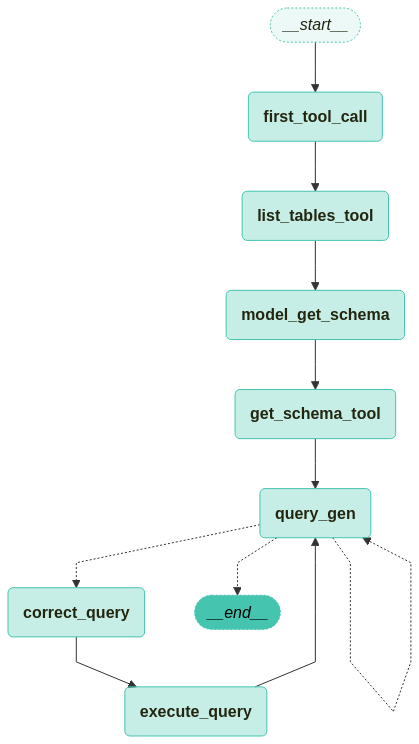

In [31]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver


# 에이전트의 상태 정의
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# 새로운 그래프 정의
workflow = StateGraph(State)


# 첫 번째 도구 호출을 위한 노드 추가
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "initial_tool_call_abc123",
                    }
                ],
            )
        ]
    }


# 쿼리의 정확성을 모델로 점검하기 위한 함수 정의
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to check that your query is correct before you run it
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


# 첫 번째 도구 호출 노드 추가
workflow.add_node("first_tool_call", first_tool_call)

# 첫 번째 두 도구를 위한 노드 추가
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# 질문과 사용 가능한 테이블을 기반으로 관련 테이블을 선택하는 모델 노드 추가
model_get_schema = ChatOpenAI(model=MODEL_NAME, temperature=0).bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)


# 최종 상태를 나타내는 도구 설명
class SubmitFinalAnswer(BaseModel):
    """쿼리 결과를 기반으로 사용자에게 최종 답변 제출"""

    final_answer: str = Field(..., description="The final answer to the user")


# 질문과 스키마를 기반으로 쿼리를 생성하기 위한 모델 노드 추가
QUERY_GEN_INSTRUCTION = """You are a SQL expert with a strong attention to detail.

You can define SQL queries, analyze queries results and interpretate query results to response an answer.

Read the messages bellow and identify the user question, table schemas, query statement and query result, or error if they exist.

1. If there's not any query result that make sense to answer the question, create a syntactically correct SQLite query to answer the user question. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

2. If you create a query, response ONLY the query statement. For example, "SELECT id, name FROM pets;"

3. If a query was already executed, but there was an error. Response with the same error message you found. For example: "Error: Pets table doesn't exist"

4. If a query was already executed successfully interpretate the response and answer the question following this pattern: Answer: <<question answer>>. For example: "Answer: There three cats registered as adopted"
"""

query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", QUERY_GEN_INSTRUCTION), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | ChatOpenAI(model=MODEL_NAME, temperature=0).bind_tools(
    [SubmitFinalAnswer, model_check_query]
)


# 조건부 에지 정의
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]

    last_message = messages[-1]
    if last_message.content.startswith("Answer:"):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# 쿼리 생성 노드 정의
def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # LLM이 잘못된 도구를 호출할 경우 오류 메시지를 반환
    tool_messages = []
    message.pretty_print()
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


# 쿼리 생성 노드 추가
workflow.add_node("query_gen", query_gen_node)

# 쿼리를 실행하기 전에 모델로 점검하는 노드 추가
workflow.add_node("correct_query", model_check_query)

# 쿼리를 실행하기 위한 노드 추가
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# 노드 간의 엣지 지정
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# 실행 가능한 워크플로우로 컴파일
app = workflow.compile(checkpointer=MemorySaver())
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)

# 그래프 실행

In [32]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph, stream_graph
from langchain_core.messages import HumanMessage
from langgraph.errors import GraphRecursionError


def run_graph(
    message: str, recursive_limit: int = 30, node_names=[], stream: bool = False
):
    # config 설정(재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    try:
        if stream:
            # 그래프 실행
            stream_graph(app, inputs, config, node_names=node_names)
        else:
            invoke_graph(app, inputs, config, node_names=node_names)
        output = app.get_state(config).values
        return output
    except GraphRecursionError as recursion_error:
        print(f"GraphRecursionError: {recursion_error}")
        output = app.get_state(config).values
        return output

In [33]:
output = run_graph(
    "Andrew Adam 직원의 인적정보를 모두 조회해줘",
    stream=False,
)


🔄 Node: first_tool_call 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (initial_tool_call_abc123)
 Call ID: initial_tool_call_abc123
  Args:

🔄 Node: list_tables_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

🔄 Node: model_get_schema 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_ez5mBqoMtZYypeAOXqs60k7Q)
 Call ID: call_ez5mBqoMtZYypeAOXqs60k7Q
  Args:
    table_names: Employee

🔄 Node: get_schema_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message ===========================

In [34]:
output = run_graph(
    "2009년도에 어느 국가의 고객이 가장 많이 지출했을까요? 그리고 얼마를 지출했을까요? 한글로 답변하세요.",
    stream=False,
)


🔄 Node: first_tool_call 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (initial_tool_call_abc123)
 Call ID: initial_tool_call_abc123
  Args:

🔄 Node: list_tables_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

🔄 Node: model_get_schema 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_JS8B77E8oOCo2FhfsvAhhAks)
 Call ID: call_JS8B77E8oOCo2FhfsvAhhAks
  Args:
    table_names: Customer, Invoice

🔄 Node: get_schema_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message ==================

# LangSmith Evaluator 를 활용한 SQL Agent 평가


In [35]:
from langsmith import Client

# 클라이언트 초기화
client = Client()

# 데이터셋 생성 및 업로드
examples = [
    (
        "Which country's customers spent the most? And how much did they spend?",
        "The country whose customers spent the most is the USA, with a total spending of 523.06.",
    ),
    (
        "What was the most purchased track of 2013?",
        "The most purchased track of 2013 was Hot Girl.",
    ),
    (
        "How many albums does the artist Led Zeppelin have?",
        "Led Zeppelin has 14 albums",
    ),
    (
        "What is the total price for the album “Big Ones”?",
        "The total price for the album 'Big Ones' is 14.85",
    ),
    (
        "Which sales agent made the most in sales in 2009?",
        "Steve Johnson made the most sales in 2009",
    ),
]

dataset_name = "SQL Agent Response"

if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)


In [36]:
# 에이전트의 SQL 쿼리 응답을 예측하기 위한 함수 정의
def predict_sql_agent_answer(example: dict):
    """Use this for answer evaluation"""
    config = RunnableConfig(configurable={"thread_id": random_uuid()})

    inputs = {
        "messages": [HumanMessage(content=example["input"])],
    }
    # 그래프를 실행하여 메시지 결과 조회
    messages = app.invoke(inputs, config)
    answer = messages["messages"][-1].content
    # 결과 반환
    return {"response": answer}

In [37]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")


# 답변 평가자 LLM-as-judge 정의
def answer_evaluator(run, example) -> dict:
    # input: 질문
    input_question = example.inputs["input"]
    # output: 참조 답변
    reference = example.outputs["output"]
    # 예측 답변
    prediction = run.outputs["response"]

    # LLM 평가자 초기화
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm

    # 평가자 실행
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]

    # 점수 반환
    return {"key": "answer_v_reference_score", "score": score}

In [38]:
from langsmith.evaluation import evaluate

# 평가용 데이터셋 이름
dataset_name = "SQL Agent Response"

try:
    # 평가 진행
    experiment_results = evaluate(
        predict_sql_agent_answer,  # 평가시 활용할 예측 함수
        data=dataset_name,  # 평가용 데이터셋 이름
        evaluators=[answer_evaluator],  # 평가자 목록
        num_repetitions=3,  # 실험 반복 횟수 설정
        experiment_prefix="sql-agent-eval",
        metadata={"version": "chinook db, sql-agent-eval: gpt-4o"},  # 실험 메타데이터
    )
except Exception as e:
    print(e)

View the evaluation results for experiment: 'sql-agent-eval-6577c631' at:
https://smith.langchain.com/o/9b141874-d093-4103-946d-7bc247255f98/datasets/879fc605-cd4f-490d-9e08-8b82765750f0/compare?selectedSessions=3a1ad9e3-724a-4c29-a624-edb6650e8fb3




0it [00:00, ?it/s]

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_4VXRwmeSIdwE1WW72TkqgCnW)
 Call ID: call_4VXRwmeSIdwE1WW72TkqgCnW
  Args:
    state: {'messages': [{'content': 'SELECT c.Country, SUM(i.Total) as TotalSpent FROM Customer c JOIN Invoice i ON c.CustomerId = i.CustomerId GROUP BY c.Country ORDER BY TotalSpent DESC LIMIT 1;', 'type': 'ai'}]}
================================== Ai Message ==================================

SELECT c.Country, SUM(i.Total) as TotalSpent FROM Customer c JOIN Invoice i ON c.CustomerId = i.CustomerId GROUP BY c.Country ORDER BY TotalSpent DESC LIMIT 1;
================================== Ai Message ==================================

Answer: The country whose customers spent the most is the USA, with a total spending of 523.06.
================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_tR81FZtG8kVh04fWBu0B4wwR)
 Call ID: call_tR81FZtG8kV

Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 2a98dba0-d34d-48b3-96a6-9abc3ff43034: RateLimitError("Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-Nlrc03jLTonhenq0ChcwpgIu on tokens per min (TPM): Limit 30000, Used 30000, Requested 293. Please try again in 586ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}")
Traceback (most recent call last):
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1634, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line 346, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\lan

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_QEPl5zQmpXm23lIP4rgRPuhz)
 Call ID: call_QEPl5zQmpXm23lIP4rgRPuhz
  Args:
    state: {'messages': [{'content': 'What was the most purchased track of 2013?', 'type': 'human'}, {'content': 'SELECT * FROM Track;', 'type': 'ai'}, {'content': 'SELECT * FROM InvoiceLine;', 'type': 'ai'}, {'content': 'SELECT * FROM Invoice;', 'type': 'ai'}]}


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-Nlrc03jLTonhenq0ChcwpgIu on tokens per min (TPM): Limit 30000, Used 29948, Requested 881. Please try again in 1.658s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Traceback (most recent call last):
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1915, in _forward
    fn(
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\run_helpers.py", line 634, in wrapper
    raise e
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\run_helpers.py", line 631, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kakao\AppData\Local\Temp\ipykernel_14980\2799409917.py", line 10, in predict_sql_ag

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_WxzycW4LwAXyet7P60F324kJ)
 Call ID: call_WxzycW4LwAXyet7P60F324kJ
  Args:
    state: {'messages': [{'content': "SELECT e.FirstName, e.LastName, SUM(i.Total) as TotalSales FROM Employee e JOIN Customer c ON e.EmployeeId = c.SupportRepId JOIN Invoice i ON c.CustomerId = i.CustomerId WHERE strftime('%Y', i.InvoiceDate) = '2009' GROUP BY e.EmployeeId ORDER BY TotalSales DESC LIMIT 1;", 'type': 'ai'}]}


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-Nlrc03jLTonhenq0ChcwpgIu on tokens per min (TPM): Limit 30000, Used 29976, Requested 967. Please try again in 1.886s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Traceback (most recent call last):
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1915, in _forward
    fn(
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\run_helpers.py", line 634, in wrapper
    raise e
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\run_helpers.py", line 631, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kakao\AppData\Local\Temp\ipykernel_14980\2799409917.py", line 10, in predict_sql_ag

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_uZxAdIDscoilr21K9AnIt5Q0)
 Call ID: call_uZxAdIDscoilr21K9AnIt5Q0
  Args:
    state: {'messages': [{'content': 'How many albums does the artist Led Zeppelin have?', 'type': 'human'}, {'content': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', 'type': 'function', 'name': 'sql_db_list_tables'}, {'content': '\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from 

Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-Nlrc03jLTonhenq0ChcwpgIu on tokens per min (TPM): Limit 30000, Used 30000, Requested 482. Please try again in 964ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Traceback (most recent call last):
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1915, in _forward
    fn(
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\run_helpers.py", line 634, in wrapper
    raise e
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\run_helpers.py", line 631, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kakao\AppData\Local\Temp\ipykernel_14980\2799409917.py", line 10, in predict_sql_age

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_WesBlmr55lHXWi7iAeswNQu7)
 Call ID: call_WesBlmr55lHXWi7iAeswNQu7
  Args:
    state: {'messages': [{'content': "Which country's customers spent the most? And how much did they spend?", 'type': 'human'}, {'content': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', 'type': 'function', 'name': 'sql_db_list_tables'}, {'content': '{"table_names":"Customer, Invoice"}', 'type': 'function', 'name': 'sql_db_schema'}, {'content': '\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"S

Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-Nlrc03jLTonhenq0ChcwpgIu on tokens per min (TPM): Limit 30000, Used 30000, Requested 204. Please try again in 408ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Traceback (most recent call last):
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1915, in _forward
    fn(
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\run_helpers.py", line 634, in wrapper
    raise e
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\run_helpers.py", line 631, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kakao\AppData\Local\Temp\ipykernel_14980\2799409917.py", line 10, in predict_sql_age

================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_yRfSTAZvKKShHqGj6EBrKMtJ)
 Call ID: call_yRfSTAZvKKShHqGj6EBrKMtJ
  Args:
    state: {'messages': [{'content': 'How many albums does the artist Led Zeppelin have?', 'type': 'human'}, {'content': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', 'type': 'function', 'name': 'sql_db_list_tables'}, {'content': '\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from 

Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-Nlrc03jLTonhenq0ChcwpgIu on tokens per min (TPM): Limit 30000, Used 29941, Requested 482. Please try again in 846ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Traceback (most recent call last):
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1915, in _forward
    fn(
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\run_helpers.py", line 634, in wrapper
    raise e
  File "C:\Users\kakao\AI_study\.venv\Lib\site-packages\langsmith\run_helpers.py", line 631, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kakao\AppData\Local\Temp\ipykernel_14980\2799409917.py", line 10, in predict_sql_age